# Collaborative Filtering for Implicit Feedback Datasets

## Methodology

A utility matrix $R$ was constructed, with `producers vector` $p$ rows and sampled artist vector $a$ columns. $R_{p,a}$ represents the number of times a given producer $p$ sampled an artist $a$, ranging from 0 to 131.

Singular Value Decomposition is a latent factor model which causes dimensionality reduction. Two matrices are created, a user-factor matrix and an item-factor matrix, where the factor represents the number of latent factors in the data. The dot product of these matrices is an attempt to reconstitute the original utility matrix. Originally, these models were trained by stochastic gradient descent, in the form of the equation below:

$\underset{x,y}min\underset{u,i}\sum 
c_{ui} (p_{ui} - x_u^Ty_i)^2 + \lambda
(\underset u \sum \parallel x_u \parallel ^2
+\underset u \sum \parallel y_i \parallel ^2)$

##### Where:

* $x_u$ is user vector
* $y_i$ is item vector
* $x_u^Ty_i$ is their dot product.

* $p_{ui} = 1$ if interaction, 0 if no interaction.

* $c_{ui} =$ our confidence in the data; in our case, the number of times a producer sampled a artist. This is calculated as $c_{ui} =1 + \alpha * r_{ui}$, where
$r_{ui}$ = # of interactions for a user-item pair, and $\alpha$ determines our confidence levels.

* $\lambda$ is regularization term.

Like other gradient descent algorithms, this model begins with taking the squared error of our prediction $(p_{ui} - x_u^Ty_i)^2$. It then multiplies our error by our confidence in this prediction, $c_{ui}$, thus increasing the cost of errors on high confidence user-item interactions. Across all or a subset of users x and items y, we minimize this cost.

In practice, however, stochastic gradient descent is impossible in implicit feedback. There are often billions of user-item interactions to compute over.

## ALS

Therefore we modify the cost function to Alternating Least Squares, which works by holding either user vectors or item vectors constant and calculating the global minimum, then alternating to the other vector.

### Compute User factors
$x_u = (Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

##### Where:

$Y$ is $n * f$ matrix of item-factors. 

$C^u$ is a $n*n$ diagonal matrix for user $u$ where $C^u_{ii} = c_{ui}$. Each $C^u$ is our confidence matrix for $n$ items for $u$ user.

$p(u)$ is vector of preferences for user $u$.

### Recompute Item factors

$y_i = (X^TC^iX + \lambda I)^-1 X^TC^ip(i)$

##### Where:
$X$ = $m * f$ matrix  of user_factors. 

$C^i$ is $m * m$ diagonal matrix for each item $i$ where $C_{uu}^i = c_{ui}$

$p(i)$ is vector of preferences for item $i$.


### Explaining recommendations

If $\hat{p}_{ui}$, the predicted preference of user $u$ at item $i$, is equal to $y_i^Tx_u$, we can substite our user_factor equation for $x_u$. This gives us:

$\hat{p}_{ui} =  y_i^T(Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

Denote $f*f$ matrix $(Y^T C^u Y + \lambda I)^{-1}$ as $W^u$

$W^u$ is considered the weight for user $u$


## Import libraries

In [43]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd

import implicit
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import os, sys
os.environ["OPENBLAS_NUM_THREADS"]="1"

import random

np.set_printoptions(threshold=sys.maxsize)

from src.test_ranking import *

## Read in the data from the Mongo collection

In [44]:
df = clean_up_mongo_coll(db.main_redo)

## Turn df to utility matrix

In [45]:
user_art = turn_df_to_util_mat_at_limits(
    df, 'new_song_producer', 'sampled_artist')

### Perform Test/Train Split

We can't do the traditional time split for recommendation systems, because the algorithm requires the entire
dataframe to train on. Instead, we create a test set by taking some percentage of the actual interactions, and 
replacing them with zeros- in other words, acting as if the producer has not sampled those artists.

We train the model on this `train` dataset with these specific values hidden. 

In [46]:
user_inds, item_inds = get_indices_of_test_set_values(user_art, 5)

train, test = make_train_set_and_test_set(user_inds, item_inds, user_art)

## Fit model on training data 

The implicit library has a fast implementation of the alternating least squares algorithm, which I use below. 

The model's fit method expects the sparse utility matrix to be as item/user- however, ours is in user-item.

Therefore, the model's item_vecs is our user_vecs, and vice versa.

## Explore Model

The item factors attribute refers to our user_vectors, since we trained it backwards

To explore the recommendations and other attributes, will probably be simplest to retrain the model with a item_user matrix.

In [15]:
user_vecs = train_model.item_factors.shape

train_model.

(16865, 100)

## Test model

We need a metric to evaluate how our model is performing on the test data.
### Ranking Algorithm

$\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$

#### where:
$r^t_{ui}$ is the # of interactions for observations in the test set, and 

$rank_{ui}$ are the percentile ranking of each item for each user.

#### Explanation

We can see that $\sum_{u,i} r^t_{ui}$ is in both the numerator and the denominator. If $rank_{ui}$ was not in the numerator, $\overline{rank}$ would simply equal 1. $rank_{ui}$ is the percentile ranking of each item for each user, such that the item most highly recommended has a $rank_{ui}$ of 0.00\% and the item least recommended has a $rank_{ui}$ of 100.00\%.

Therefore, if the algorithm is correct, the low percentages will cancel out the high $r^t_{ui}$, making the $\overline{rank}$ go towards 0.

#### Methodology

1. Get denominator by summing the # of user-item interactions at the test set indices. This is $\sum_{u,i} r^t_{ui}$, for  $\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$   

2. Get the $rank_{ui}$ of our model for all $u, i$ in $r^t_{ui}$. This is calculated by getting the predictions of the ALS model, ranking them, taking their percentage, and then selecting only the ones at the selected indices.

3. Get $rtui$ 

4. Multiply $rank_{ui}$ by $r^t_{ui}$ to get numerator. Divide by $rank_{ui}$ to get $\overline{rank}$

5. Use popularity as a baseline for the model. Instead of using the model to rank different songs for artists, the $rank_{ui}$ of popularity for all $u, i$ in $r^t_{ui}$. This is popularity rank score.

## Putting it all together

In Yuwan He's paper, they say that more factors is better without fail.
So I originally try to run the model with 400 factors.

In [5]:
rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 400)

print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score, pop_rank_score))



100%|██████████| 50.0/50 [00:54<00:00,  1.12s/it]


Model rank score: 0.47191961201452126 
Popularity rank score: 0.092568318220976


The rank_score is nearly the same as random (0.45), while popularity is closer to 0.1

## Evaluation
My model does not do as well as popularity unfortunately.

# Testing at different # of factors

I find that 8 factors is best.

In [11]:
# Look up factors between 2 and 400

a = list(range(2, 20, 2))
b = list(range(20,200, 40))
factors = a + b
vals_facts = []

for factor in factors:
    
    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, factor, regularization = 46.4)

    vals_facts.append([factor, rank_score, pop_rank_score])



100%|██████████| 50.0/50 [00:01<00:00, 40.14it/s]
100%|██████████| 50.0/50 [00:01<00:00, 29.33it/s]
100%|██████████| 50.0/50 [00:10<00:00,  4.87it/s]
100%|██████████| 50.0/50 [00:02<00:00, 24.20it/s]
100%|██████████| 50.0/50 [00:12<00:00,  4.02it/s]
100%|██████████| 50.0/50 [00:12<00:00,  3.83it/s]
100%|██████████| 50.0/50 [00:12<00:00,  4.39it/s]
100%|██████████| 50.0/50 [00:11<00:00,  4.42it/s]
100%|██████████| 50.0/50 [00:13<00:00,  3.74it/s]
100%|██████████| 50.0/50 [00:12<00:00,  4.35it/s]
100%|██████████| 50.0/50 [00:15<00:00,  3.20it/s]
100%|██████████| 50.0/50 [00:17<00:00,  2.81it/s]
100%|██████████| 50.0/50 [00:22<00:00,  2.23it/s]
100%|██████████| 50.0/50 [00:27<00:00,  1.93it/s]


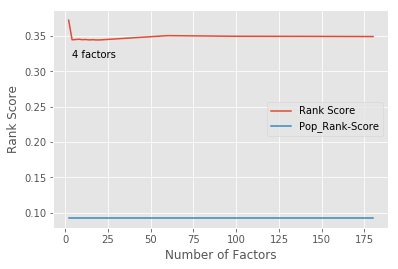

In [18]:
fig, ax = plt.subplots()

ax.plot(factors, [val[1] for val in vals_facts], label = "Rank Score")
ax.plot(factors, [val[2] for val in vals_facts], label = "Pop_Rank-Score")
ax.legend(loc = 'best')
ax.annotate(xy = (4, .32), s = "4 factors")
_ = ax.set(ylabel = "Rank Score", xlabel = "Number of Factors")

# Testing at different values of lambda

First I check between np.logspace(0, 2, 7)), and find the best values to be at 46.4.

46.4 is best, better then 21 or 100. I'd like to search this area further

In [21]:
regularizations = range(30,100, 10)

#regularizations = regularizations1 + regularizations2
vals_at_lams = []

for regularization in regularizations:
    
    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 6, regularization)

    vals_at_lams.append([regularization, rank_score, pop_rank_score])


100%|██████████| 50.0/50 [00:11<00:00,  4.63it/s]
100%|██████████| 50.0/50 [00:11<00:00,  4.32it/s]
100%|██████████| 50.0/50 [00:11<00:00,  4.95it/s]
100%|██████████| 50.0/50 [00:10<00:00,  4.66it/s]
100%|██████████| 50.0/50 [00:10<00:00,  4.96it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.10it/s]
100%|██████████| 50.0/50 [00:07<00:00,  7.95it/s]


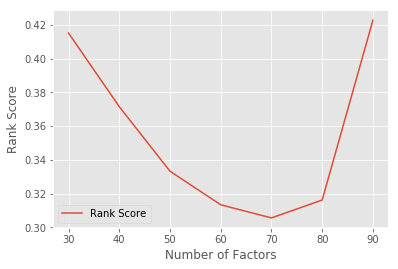

In [22]:
fig, ax = plt.subplots()

ax.plot(regularizations, [val[1] for val in vals_at_lams], label = "Rank Score")
#ax.plot(regularizations, [val[2] for val in vals], 'ro',label = "Pop_Rank-Score")
ax.legend(loc = 'best')
#ax.annotate(xy = (100, .335), s = ".1 Lambda")
_ = ax.set(ylabel = "Rank Score", xlabel = "Lambda Values")

In [25]:
rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, factors = 4, regularization = 70, iterations = 50)

print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score, pop_rank_score))

100%|██████████| 50.0/50 [00:01<00:00, 33.17it/s]


Model rank score: 0.30968148060263645 
Popularity rank score: 0.092568318220976


## Grid Search lambda and factors

In [27]:
regularizations =range(65, 75, 3)
factors = range(4, 11, 3)

vals_grid_search = []
for regularization in regularizations:
    
    for factor in factors:

        rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
        train, test, user_inds, item_inds, factor, regularization)

        vals_grid_search.append([regularization, rank_score, pop_rank_score])

100%|██████████| 50.0/50 [00:01<00:00, 33.26it/s]
100%|██████████| 50.0/50 [00:10<00:00,  2.84it/s]
100%|██████████| 50.0/50 [00:10<00:00,  4.68it/s]
100%|██████████| 50.0/50 [00:01<00:00, 32.52it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.41it/s]
100%|██████████| 50.0/50 [00:10<00:00,  5.17it/s]
100%|██████████| 50.0/50 [00:01<00:00, 33.17it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.58it/s]
100%|██████████| 50.0/50 [00:10<00:00,  5.23it/s]
100%|██████████| 50.0/50 [00:01<00:00, 35.56it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.71it/s]
100%|██████████| 50.0/50 [00:10<00:00,  5.33it/s]


The best value comes at 74 reg, and 10 factors.

In [31]:
vals_grid_search

[[65, 0.30822434428555595, 0.092568318220976],
 [65, 0.3086632306032443, 0.092568318220976],
 [65, 0.3091274360925995, 0.092568318220976],
 [68, 0.3075001986084951, 0.092568318220976],
 [68, 0.3054364938358423, 0.092568318220976],
 [68, 0.3065717131981188, 0.092568318220976],
 [71, 0.30921279680805264, 0.092568318220976],
 [71, 0.3040438029361109, 0.092568318220976],
 [71, 0.3033146703374379, 0.092568318220976],
 [74, 0.30414288388863575, 0.092568318220976],
 [74, 0.3063357772226499, 0.092568318220976],
 [74, 0.30057376145832077, 0.092568318220976]]

## Testing different values of iterations

In [32]:
# Look up factors between 2 and 400

iterations = range(10, 510, 100)
vals_iters = []

for iteration in iterations:
    
    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 10, 74, iteration)

    vals_iters.append([iteration, rank_score, pop_rank_score])

100%|██████████| 10.0/10 [00:02<00:00,  5.11it/s]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()

ax.plot(iterations, [val[1] for val in vals_iters], label = "Rank Score")
ax.plot(iterations, [val[2] for val in vals_iters], label = "Pop_Rank-Score")
ax.legend(loc = 'best')
_ = ax.set(ylabel = "Rank Score", xlabel = "Number of Iterations")

## Try different num_prods, num_artists

The reason I am getting a low score is likely because the model is having to train on producers with few artists sampled, and artists who have been sampled infrequently.

For instance, 1000 producers have 0 samples in the training set!

By limiting to greater than 4 samples per producer, the matrix reaches 99.887 % sparsity, from 99.971 previously.

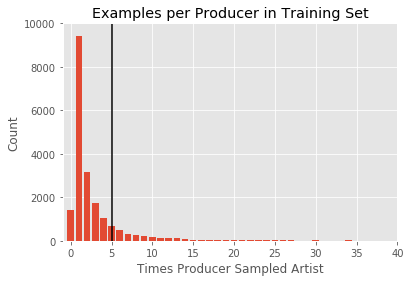

In [170]:
#Plot number interactions 

samples_per_prod = train.sum(axis = 1)
counts = samples_per_prod.value_counts().sort_index()

fig, ax = plt.subplots()
ax.set(ylim = (0,10000), xlim = (-1, 40), 
       title = "Examples per Producer in Training Set",
       xlabel = "Times Producer Sampled Artist", 
       ylabel = "Count")
ax.axvline(5, color ='black')
_ = ax.bar(counts.index, counts.values)

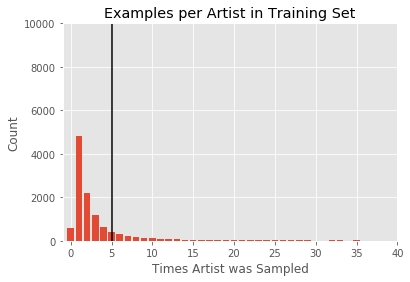

In [173]:
#Plot number interactions 

times_sampled_by_artist = train.sum(axis = 0)
counts = times_sampled_by_artist.value_counts().sort_index()

fig, ax = plt.subplots()
ax.set(ylim = (0,10000), xlim = (-1, 40), 
       title = "Examples per Artist in Training Set",
       xlabel = "Times Artist was Sampled", 
       ylabel = "Count")
ax.axvline(5, color ='black')
_ = ax.bar(counts.index, counts.values)

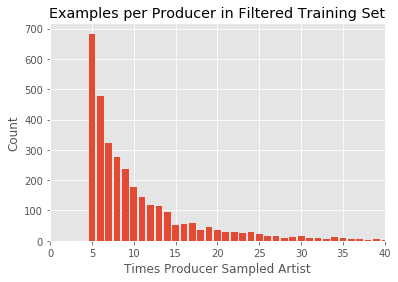

In [172]:
# Limit dataframes for model building to samples with requisite interactions.

def filter_dataset_by_requisite_interactions(train, test, user_lim = None, item_lim = None):
    
    '''
    Input: 
        train: The training data
        test: The test data
        user_lim: The lower limit of interactions you will accept for user
        item_lim: The lower limit of interactions you will accept for items

    Returns: 
        train_lim: Training set with users and items above user_lim and item_lim
        test_lim: Test set with users and items above user_lim and item_lim
        user_inds_lim: New user indices 
        item_inds_lim: New item indices
        
    '''
    
    if user_lim:
        
        #Count interactions for each user
        inters_per_user = train.sum(axis = 1)
        
        #Get a list of users with more than user_lim of interactions.
        users_above_lim = list(inters_per_user[inters_per_user > user_lim].index)
    
    else:
        
        #If user_lim not provided, simply get the users
        users_above_lim = list(train.index)
    if item_lim:
        
        #Count interactions for each item
        inters_per_item = train.sum(axis = 0)
        
        #Get a list of items with more than item_lim of interactions.
        items_above_lim = list(inters_per_item[inters_per_item > item_lim].index)
    else:
        items_above_lim = list(train.columns)
    
    # filter the training and test sets to only have these producers
    train_lim = train.loc[users_above_lim, items_above_lim]
    test_lim = test.loc[users_above_lim, items_above_lim]

    #For the ranking, need the indices of this subset.
    #Find where train and test differ- this seems to work.
    inds_lim = np.where(train_lim != test_lim)

    user_inds_lim= inds_lim[0]
    item_inds_lim = inds_lim[1]
    
    return train_lim, test_lim, user_inds_lim, item_inds_lim

fig, ax = plt.subplots()
ax.set(xlim = (0, 40), 
       title = "Examples per Producer in Filtered Training Set",
       xlabel = "Times Producer Sampled Artist", 
       ylabel = "Count")
_ = ax.bar(counts4.index, counts4.values)

In [167]:
rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train_g4, test_g4, user_inds_g4, item_inds_g4, 10, 74, 50)

print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score, pop_rank_score))



100%|██████████| 50.0/50 [00:04<00:00, 11.67it/s]


Model rank score: 0.21591643528638602 
Popularity rank score: 0.03369405366560718


In [98]:
# What is the sparsity?
# How sparse is matrix?
matrix_size = test_g4.shape[0]*test_g4.shape[1] # Number of possible interactions in the matrix
nonzeros = sum(test_g4.sum(axis=0))
sparsity = 100*(1 - (nonzeros/matrix_size))
print("Matrix has {} interactions out of {} possible, resulting in a {} % sparse matrix"
          .format(nonzeros, matrix_size, round(sparsity, 3)))

#We have a matrix that is 99.8% sparse. Kind of a problem. According to https://jessesw.com/Rec-System/ 
# maximum is 99.5%

#If we go by artist, we get down to 99.765%

Matrix has 94488 interactions out of 39607484 possible, resulting in a 99.761 % sparse matrix


In [151]:
vals_lim = []

for num_prod in range(1, 15, 3):
    for num_artist in range(1, 15, 3):
        
        user_art_lim = turn_df_to_util_mat_at_limits(
            df, 'new_song_producer', 'sampled_artist', num_prod, num_artist)
        
        user_inds_lim, item_inds_lim = get_indices_of_test_set_values(user_art_lim, 5)

        train_lim, test_lim = make_train_set_and_test_set(user_inds_lim, item_inds_lim, user_art_lim)

        rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
        train_lim, test_lim, user_inds_lim, item_inds_lim, 4, 70, 50)  
        
        vals_lim.append([num_prod, num_artist, rank_score, pop_rank_score])
        
pd.DataFrame(vals_lim).to_csv('diff_limits_prods_artists_best_Friday.csv')

100%|██████████| 50.0/50 [00:06<00:00,  7.86it/s]
100%|██████████| 50.0/50 [00:05<00:00,  9.63it/s]
100%|██████████| 50.0/50 [00:05<00:00,  9.58it/s]
100%|██████████| 50.0/50 [00:04<00:00, 11.58it/s]
100%|██████████| 50.0/50 [00:04<00:00, 12.26it/s]
100%|██████████| 50.0/50 [00:04<00:00, 12.30it/s]
100%|██████████| 50.0/50 [00:02<00:00, 18.29it/s]
100%|██████████| 50.0/50 [00:02<00:00, 20.79it/s]
100%|██████████| 50.0/50 [00:02<00:00, 22.51it/s]
100%|██████████| 50.0/50 [00:02<00:00, 23.57it/s]
100%|██████████| 50.0/50 [00:03<00:00, 15.32it/s]
100%|██████████| 50.0/50 [00:02<00:00, 24.11it/s]
100%|██████████| 50.0/50 [00:01<00:00, 28.18it/s]
100%|██████████| 50.0/50 [00:01<00:00, 31.36it/s]
100%|██████████| 50.0/50 [00:01<00:00, 33.24it/s]
100%|██████████| 50.0/50 [00:02<00:00, 17.09it/s]
100%|██████████| 50.0/50 [00:01<00:00, 28.49it/s]
100%|██████████| 50.0/50 [00:01<00:00, 33.67it/s]
100%|██████████| 50.0/50 [00:01<00:00, 37.73it/s]
100%|██████████| 50.0/50 [00:01<00:00, 41.00it/s]


[[1, 1, 0.47463980327615485, 0.10561007763292808], [1, 4, 0.514713416102744, 0.14535797752517524], [1, 7, 0.510284662777066, 0.16146524925004327], [1, 10, 0.4815849534858039, 0.17642855640339297], [1, 13, 0.46994730007286467, 0.18440959959987918], [4, 1, 0.4900939299976194, 0.11031763550372505], [4, 4, 0.535751922678408, 0.15053541616703026], [4, 7, 0.5269113742400596, 0.16482895248295162], [4, 10, 0.4903232741466841, 0.18738297856627667], [4, 13, 0.4736181164613526, 0.19268857877717485], [7, 1, 0.545244204487025, 0.13561170172889073], [7, 4, 0.5493365127847887, 0.15143039591315455], [7, 7, 0.553194353136469, 0.1773736363099297], [7, 10, 0.4956875328952954, 0.1991562212045582], [7, 13, 0.4624774067415621, 0.1984361956703211], [10, 1, 0.4958041750910137, 0.12106190625663563], [10, 4, 0.5193434088373656, 0.1518519300376573], [10, 7, 0.5440420645175508, 0.17817578260076267], [10, 10, 0.5210090294912388, 0.18883905473653764], [10, 13, 0.47444973376193167, 0.20663684706822638], [13, 1, 0.52

## Plot results in Plotly

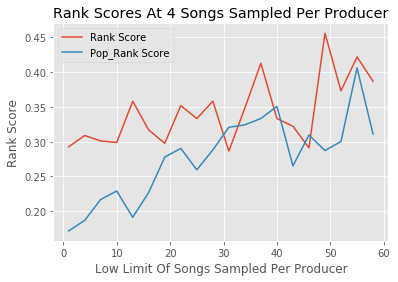

In [106]:
fig, ax = plt.subplots()

#Subset to take only vals with 40 producers +
vals_sub = [val for val in vals_lim if val[0] == 4]

ax.plot([val[1]for val in vals_sub], [val[2] for val in vals_sub], label = "Rank Score")
ax.plot([val[1]for val in vals_sub], [val[3] for val in vals_sub], label = "Pop_Rank Score")
# ax.plot(iterations, [val[2] for val in vals], label = "Pop_Rank-Score")
ax.legend(loc = 'best')
_ = ax.set(ylabel = "Rank Score", xlabel = "Low Limit Of Songs Sampled Per Producer", 
          title = "Rank Scores At 4 Songs Sampled Per Producer")

In [167]:
import plotly
import plotly.graph_objs as go

data = [go.Scatter3d(
    x= np.array([val[0]for val in vals_lim]),
    y= np.array([val[1] for val in vals_lim]),
    z= np.array([val[2] for val in vals_lim]),
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ), 
    yaxis=dict(range=[60, 0],title = "Lower Limit of Times Artists Sampled"),
    xaxis =dict(range=[60, 0], title = "Lower Limit of Sampled Artits Per Producer")
)
plotly.offline.plot({"data":data, "layout":layout})

'file:///Users/jesse/Documents/recordmender/temp-plot.html'

## Limits of Producer/Artist that give best Rank Score

I find that only working with producers > 40 samples, artists > 58 samples is best. But how many data points is that actually?

That is only 444 producers on 263 artists. Likely the data is just too sparse.

There is no clear pattern to the data- the rank score is not getting better for producers with more data.

In [171]:
#Finding values with min_rank_score
min_rank_score = np.amin(np.array(vals_lim)[:, 2])
idx_min_rank = np.argmin(np.array(vals_lim)[:, 2])
print(vals_lim[idx_min_rank])
print(min_rank_score)

#Get number of artists/ producers at that value.
#user_art = turn_df_to_util_mat_at_limits(
#            df, 'new_song_producer', 'sampled_artist', 40, 58)

[10, 0.4466928807135686, 0.08840700417907066]
0.08840700417907066


## Split df by element sampled

Should we put interpolations in there? Not now.

In [152]:
elements = [None, "Direct Sample of Vocals / Lyrics", 
            'Direct Sample of Drums', 'Direct Sample of Bass',
            'Direct Sample of Multiple Elements', 
            'Direct Sample of Hook / Riff']
rank_scores = []

pop_scores = []

for element in elements:
    if element:
    #filter df by element
        df_elem = df[df.elements_sampled == element]
    else: 
        df_elem = df
    #turn to utility
    user_art_elem = turn_df_to_util_mat_at_limits(
        df_elem, 'new_song_producer', 'sampled_artist')
    
    #make train and test sets
    user_inds_elem, item_inds_elem = get_indices_of_test_set_values(user_art_elem, 5)
    train_elem, test_elem = make_train_set_and_test_set(user_inds_elem, item_inds_elem, user_art_elem)
    
    rank_score, pop_score = get_rank_and_pop_score_from_train_test_model(
        train_elem, test_elem, user_inds_elem, item_inds_elem, factors = 10, regularization = 74, iterations = 50)
    rank_scores.append(rank_score)
    pop_scores.append(pop_score)


100%|██████████| 50.0/50 [00:12<00:00,  4.21it/s]
100%|██████████| 50.0/50 [00:04<00:00, 11.98it/s]
100%|██████████| 50.0/50 [00:02<00:00, 19.64it/s]
100%|██████████| 50.0/50 [00:00<00:00, 148.53it/s]
100%|██████████| 50.0/50 [00:05<00:00,  8.64it/s]
100%|██████████| 50.0/50 [00:02<00:00, 22.38it/s]


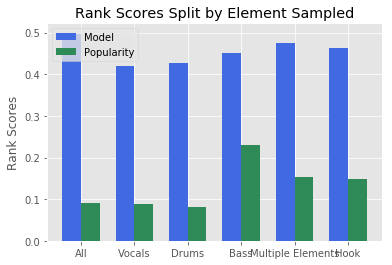

In [178]:
labels = ['All', 'Vocals', 'Drums', 'Bass', 'Multiple Elements', 'Hook']

N = 6

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, rank_scores, width, color='royalblue')
rects2 = ax.bar(ind+width, pop_scores, width, color='seagreen')

# add some
ax.set_ylabel('Rank Scores')
ax.set_title('Rank Scores Split by Element Sampled')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( labels )

_ = ax.legend( (rects1[0], rects2[0]), ('Model', 'Popularity'), loc = 'upper center' )

# Feature Engineering - Can it recommend a year? An album?

In [37]:
def get_rank_and_pop_score_of_two_columns(df, col1, col2, split_pct, factors = 10, regularization = 74, iterations = 50):
    
    '''
    Input: 
        Col1: Users
        Col2: Items
        Df: Dataframe to get columns data from
        Split.pct: % of data to send to hide for testing.
        Factors, regularization, iterations: Parameters for the ALS algorithm
        
    Returns: Rank_score and pop_score of those two columns
    '''
    
    user_item = turn_df_to_util_mat_at_limits(
            df, col1, col2)

    user_inds, item_inds = get_indices_of_test_set_values(user_item, split_pct)

    train, test = make_train_set_and_test_set(user_inds, item_inds, user_item)

    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
        train, test, user_inds, item_inds, factors, regularization ,iterations)
    
    return rank_score, pop_rank_score

## Try with sampled_song

It's possible (?) that the recommender will work better to recommend songs to sample, not artists. Unlikely.

Also maybe it will find a better relationship between new_song_artist and sampled_song_artist, or new_song_artist and sampled_song

We would also need to grid search this. 

In [40]:
rank_score_artist, pop_rank_score_artist = get_rank_and_pop_score_of_two_columns(
    df, 'new_song_producer', 'sampled_artist_song', 5)

print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score_artist, pop_rank_score_artist))

100%|██████████| 50.0/50 [00:11<00:00,  4.49it/s]


Model rank score: 0.5776208001692504 
Popularity rank score: 0.16441753060147554


### Album

In [ ]:
rank_score_album, pop_rank_score_album = get_rank_and_pop_score_of_two_columns(df, 'new_song_producer', 'sampled_song_album', 5)

print(
    "Model rank score: {} \n\
    Popularity rank score: {}".format(rank_score, pop_rank_score))
    

## Year

## Repeat the above, but with new_song_artist instead of new_song_producer

## Logged Data

Hu's paper, they log transfomed the data by following this paper:
“Item-based top-N recom-mendation algorithms" - M DESHPANDE - 2004

They mention two strategies:

1. Multiply $P(j|i)$ by $−log_2(P(j))$ [Salton 1989] 

2. Divide $P(j|i)$ by $P(j)$ [Kitts et al. 2000].

But first they have to do:

$P(j|i)$ is the number of customers that purchase both items $i$ and $j$ divided by the total number of customers that purchased $i$, that is,
$P(j|i)= Freq(ij), Freq(i)$
where $Freq(X)$ is the number of customers that have purchased the items in the set X.

In [ ]:
import math
artist_prod_log = artist_prod.applymap(lambda x: math.log(x, 30) if x != 0 else 0)
plot_distributions_of_numbers_sampled(artist_prod_log, 'Log')

#log 10 still looks very skewed.
#they used log 6.
#Log 20 still skewed.

## Go through None Listed on producers

#### How many have all None Listed?
33 percent have none Listed for producers!

If they have None Listed for contributor (about 40), that probably means it failed. Because contributor is always listed.

Certain artists have more none listed than others.

Nearly 1/2 of the cells with missing producers are where the artist occurs less than 5 times in the df.

From the pie chart, nearly 3/4 of the missing producers are from artists who appear only 3 or less times in the dataset.



In [177]:
for col in df.columns:
    print("{} has {} with None Listed".format(col, len(df[df[col] == "None Listed" ])))

URL has 0 with None Listed
_id has 0 with None Listed
contributor_points has 48 with None Listed
elements_sampled has 44 with None Listed
name_of_contributor has 48 with None Listed
new_song_album has 18662 with None Listed
new_song_artist has 41 with None Listed
new_song_name has 41 with None Listed
new_song_producer has 64868 with None Listed
new_song_year has 42 with None Listed
presence_of_"and throughout"_in_description has 14987 with None Listed
sampled_artist has 1216 with None Listed
sampled_song_album has 20203 with None Listed
sampled_song_name has 1216 with None Listed
sampled_song_producer has 7 with None Listed
sampled_song_year has 2917 with None Listed
time_in_sampled_song_where_sample_appears has 14993 with None Listed


In [216]:
#Remove rows without artist, there's about 30
df = df[df.new_song_artist != "None Listed"]

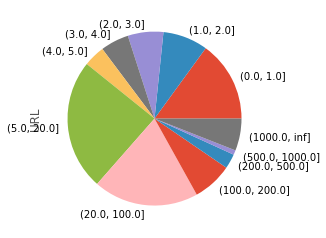

In [207]:
# Get the number of cells that are missing producer information
# for each new_song_artist and sort by artist with most missing.

df_none_listed_counts_per_artist = df[df.new_song_producer == "None Listed" ].\
    groupby("new_song_artist").\
    count()['URL'].sort_values(ascending = False)

# bin the none_listed_counts_per_artist, and take the mean and count
# of each bin

mean_per_bin = df_none_listed_counts_per_artist.groupby(
    pd.cut(df_none_listed_counts_per_artist, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    mean()

counts_per_bin = df_none_listed_counts_per_artist.value_counts().groupby(
    pd.cut(df_none_listed_counts_per_artist.value_counts().
    index, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    sum()

# #Mulitply together to the number of missing values 

num_cells_missing_prod_by_num_artist = mean_per_bin * counts_per_bin

# This has the correct sum, showing that this methodology was successful.

_ = num_cells_missing_prod_by_num_artist.plot(kind='pie')


# Replace "None Listed" in new_song_producer with new_song_artist

In [217]:
#Replace none_listed in new_song_producer with NA

df.new_song_producer = df.new_song_producer.replace("None Listed", np.nan)

#Count number of NA in new_song_producer per new_song_artist. 
#Had to create a new dataframe in the process.
#Then join the 2 dataframes, and drop the extra columns formed by the join.
df2 = df['new_song_producer'].isnull()\
    .groupby(df['new_song_artist'])\
    .sum().astype(int).reset_index(name='num_producer_missing_per_artist')


df = df.join(df2.set_index('new_song_artist'), on ='new_song_artist', lsuffix='l')

#This line wasn't necessary the second time- not sure why
#df.drop(columns = ['num_producer_missing_per_artistl', '2'], inplace = True)

# Split the data into 2016 after and before.


In [4]:
# What percentage of the data is 2018, 2017, etc?

np.cumsum(df.groupby('new_song_year').count()['URL'].apply(
    lambda x: (x / len(df)) * 100 ).sort_index(
    ascending = False))

# If we take the data past 2016-2019 as our test set, we get about 5%.

new_song_year
2019      0.127584
2018      1.752243
2017      3.614425
2016      5.619121
2015      8.069004
2014     10.856848
2013     14.537780
2012     18.091127
2011     21.231863
2010     24.333238
2009     26.670467
2008     29.158353
2007     31.654383
2006     34.037759
2005     36.783528
2004     39.245626
2003     41.907244
2002     44.100601
2001     46.638707
2000     49.208030
1999     52.375911
1998     55.539721
1997     58.646525
1996     62.246020
1995     65.739647
1994     70.241731
1993     74.872755
1992     80.081979
1991     84.847374
1990     88.833693
           ...    
1982     98.813741
1981     98.892463
1980     98.946754
1979     99.013261
1978     99.082482
1977     99.134058
1976     99.201922
1975     99.280644
1974     99.363438
1973     99.455732
1972     99.523596
1971     99.611819
1970     99.686469
1969     99.771978
1968     99.857486
1967     99.892775
1966     99.929422
1965     99.940280
1964     99.944352
1963     99.951138
1962     99.96335

In [280]:
test = df[df.new_song_year > 2014]
train = df[df.new_song_year < 2015]
print(test.shape)
print(train.shape)

(5945, 18)
(67732, 18)


In [297]:
# Songs and users have to be in both, right?

#get intersection of sampled_artist and song_producer from train and test set
def get_intersection_of_train_and_test_set(train, test, column):
    
    '''
    Takes train and test set and a column, and returns both filtered
    to have values they both share
    '''
    test_column = set(test[column])
    train_column = set(train[column])
    both_columns = test_column.intersection(train_column)
    print([len(test_column), len(train_column), len(both_columns)])
    
    test = test[test[column].isin(list(both_columns))]

    train = train[train[column].isin(list(both_columns))]
    
    return train, test

train, test = get_intersection_of_train_and_test_set(
    train, test, "sampled_artist")
train, test = get_intersection_of_train_and_test_set(
    train, test, "new_song_producer")

#I needed to run this 3 times to work

#I have 1163 artists, and 544 producers shared. 

[1163, 1164, 1163]
[544, 544, 544]
